Objectif : observer comment la dynamique de diffusion du magma au sein de réseau change avec la géometrie du réseau.

1. On tire des chambres (coordonnées centre et rayon)
2. On fait varier la coordonnée r pour se placer dans différentes conditions, de toutes les chambres parfaitement alignées à des chambres très hétérogenement positionées
3. Pour toutes ces configurations on calcule la pression au cours du temps, pour un cas libre et dans un cas forcé

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Importations
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import networkx as nx

from copy import deepcopy
from matplotlib import cycler
from matplotlib.ticker import FuncFormatter



from utilities import plot_3D_geometry

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams.update({'font.size': 14,'legend.fontsize':14})
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["axes.prop_cycle"] = cycler('color',['b', 'g', 'r', 'c', 'm', 'y', 'k'])

In [3]:
# Constantes

G_hostrock = 2.1e9 # Host rock shear modulus (Pa)
nu_hostrock = 0.25 # Host rock Poisson ratio
mu_melt = 1. # Magma viscosity (Pa.s)

## 1. Construction des géométries

In [4]:
# Random number generator
randomgen=np.random.default_rng(2000) # fixed seed, for reproductibility

In [5]:
# Paramètres 
n_sills = 10 
volume_depth_top = 3. ; volume_depth_bottom = 30. 
volume_radius = 1. # pas utilisé directement, voir r_rnd_normal_std

r_rnd_normal_mean = 0. ; r_rnd_normal_std = 0.75
t_rnd_unif_min = 0.; t_rnd_unif_max = 2*np.pi
R_rnd_lognormal_mean = 0.; R_rnd_lognormal_std = 0.2
R_rnd_lognormal_scale = 1; # Radius of sills

In [6]:
# Détermination des connections

def barycenter(x1, R1, x2, R2):
    return (R1*x2 + R2*x1)/(R1+R2)

def make_sill_connections(sills_xyzR):
    
    conduit_xyzz = []
    
    for i in range(n_sills): # loop over sills, assuming that sills are sorted in decreasing order of depth
        xi, yi, zi, Ri = sills_xyzR[i,:]
        
        for j in range(i+1, n_sills): # loop over other sills above
            xj, yj, zj, Rj = sills_xyzR[j,:]
            
            dij = np.sqrt((xj-xi)**2+(yj-yi)**2) # distance between sill centers
            if dij < Ri + Rj: # the two sills have an intersection
                xa, ya = barycenter(np.array([xi,yi]), Ri, np.array([xj,yj]), Rj) # coordinates of connection between the sills
                
                test_intersect = False
                for k in range(i+1, j): # check if connection intersects a third sill
                    xk, yk, zk, Rk = sills_xyzR[k,:]
                    dka = np.sqrt((xk-xa)**2+(yk-ya)**2) # distance between connection and third sill
                    #print("  Check: i=%d (%.2f) ; j=%d (%.2f) ; k=%d (%.2f)" % (i,Ri,j,Rj,k,Rk))
                    if dka < Rk: # connection intersects the third sill
                        test_intersect = True # intersection: ignore connection
                        break
                    
                if not(test_intersect): # no intersection: append connection
                    conduit_xyzz.append([i, j, xa, ya, zi, zj])
                    
    return np.array(conduit_xyzz)

In [7]:
def build_graph(sills_xyzR, conduits_xyzz):
    
    n_sills = sills_xyzR.shape[0]

    G = nx.Graph()

    # 1. ajout des noeuds
    
    gamma_hostrock = 8*(1-nu_hostrock)/(3*np.pi)
    
    for i in range(n_sills):
        G.add_node(i, compressibility = np.pi*(sills_xyzR[i,3]*1e3)**3*gamma_hostrock/G_hostrock)
        
    # 2. ajout des arrêtes
    
    radius_conduits = 1.
    
    for i,j,_,_,zi,zj in conduits_xyzz:
        i,j = int(i),int(j)
        height_conduit = np.abs(zj-zi)*1e3
        conductivity = np.pi*radius_conduits**4/(8*mu_melt*height_conduit)
        G.add_edge(
            i,j,
            height = height_conduit,
            conductivity = conductivity,
            resistivity = 1/conductivity
            )

    return G

def plot_graph(G):
    
    fig,ax = plt.subplots()

    options_nxdraw = {
        #"font_size": 36,
        #"node_size": 3000,
        "node_color": "white",
        "edgecolors": "black",
        #"linewidths": 5,
        #"width": 5,
    }
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos,ax=ax, **options_nxdraw)

    # Set margins for the axes so that nodes aren't clipped
    ax.margins(0.1)
    plt.axis("off")
    
    return fig,ax

In [8]:
# Tirage aléatoire des sills

r_rnd = np.abs(randomgen.normal(r_rnd_normal_mean, r_rnd_normal_std, n_sills))
t_rnd = randomgen.uniform(t_rnd_unif_min, t_rnd_unif_max, n_sills)
z_rnd = randomgen.uniform(volume_depth_top, volume_depth_bottom, n_sills)
R_rnd = R_rnd_lognormal_scale * randomgen.lognormal(R_rnd_lognormal_mean, R_rnd_lognormal_std, n_sills) 

x_rnd = r_rnd * np.cos(t_rnd)
y_rnd = r_rnd * np.sin(t_rnd)

sills_rtzR = np.vstack([r_rnd,t_rnd,z_rnd,R_rnd]).T
sills_xyzR = np.vstack([x_rnd,y_rnd,z_rnd,R_rnd]).T

# Sort by decreasing depth
sills_rtzR = sills_rtzR[sills_rtzR[:,2].argsort()][::-1]
sills_xyzR = sills_xyzR[sills_xyzR[:,2].argsort()][::-1]

In [9]:
conduits_xyzz = make_sill_connections(sills_xyzR)

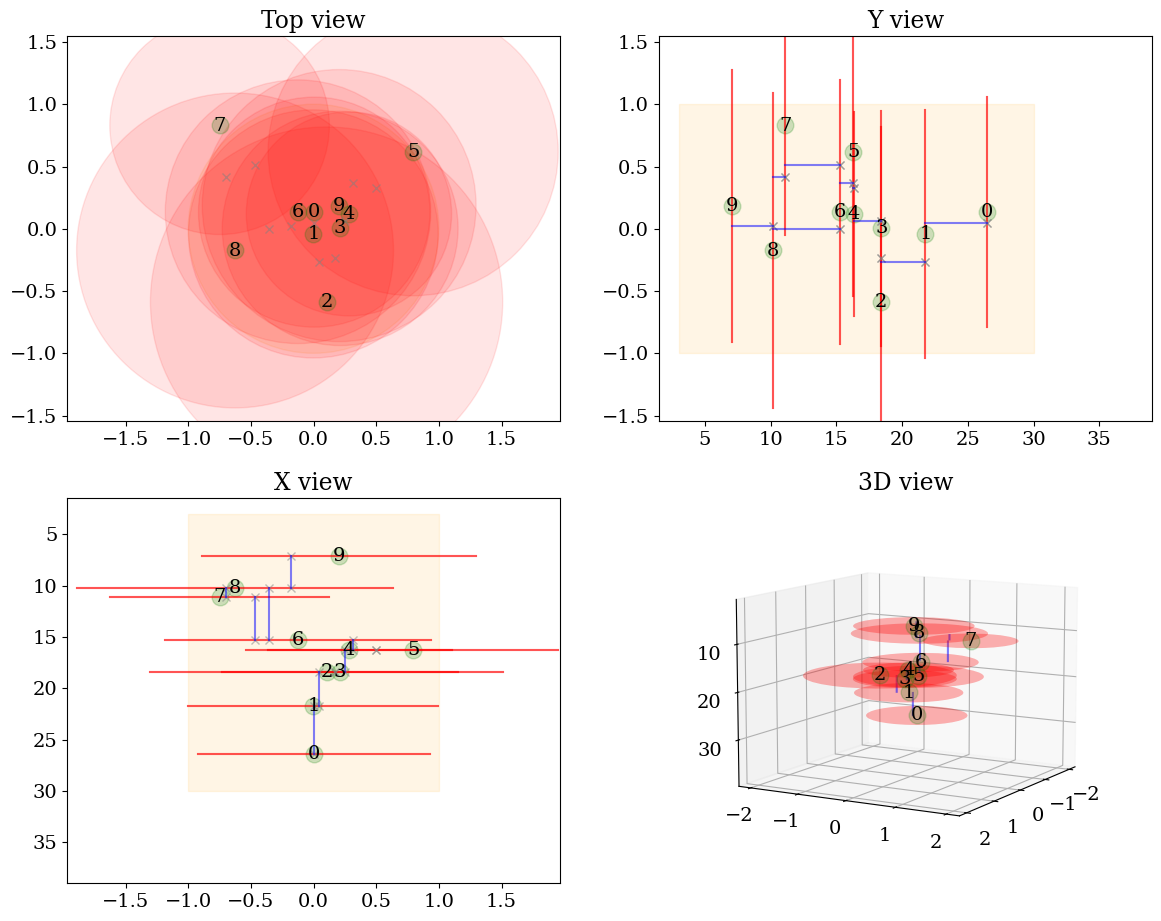

In [10]:
fig,axs = plot_3D_geometry(sills_xyzR,conduits_xyzz,volume_depth_top,volume_depth_bottom,volume_radius)
plt.show()

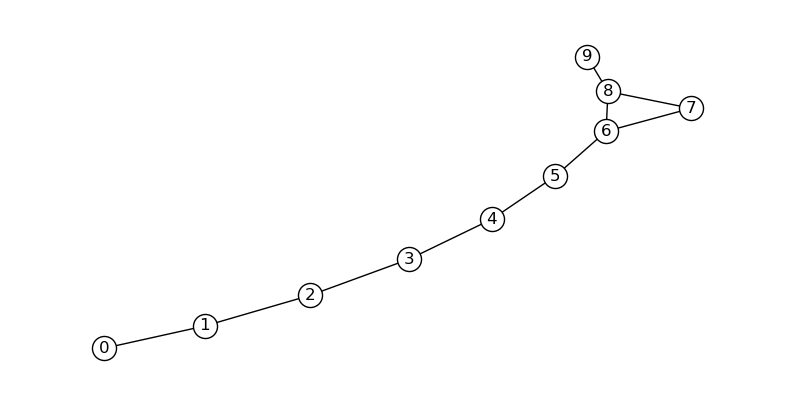

In [11]:
G = build_graph(sills_xyzR,conduits_xyzz)
fig,ax = plot_graph(G)
plt.show()

In [13]:
# On fait varier un facteur multiplicateur sur r 

n_config = 10
# r_coeff = np.linspace(0.,3.,n_config)
r_std = np.linspace(0.,2.,n_config)

sills_rtzR_variantes = []
sills_xyzR_variantes = []
conduits_xyzz_variantes = []

graphs_variantes = []

for i,r_s in enumerate(r_std):
    
    sills_rtzR_variantes.append(deepcopy(sills_rtzR))
    sills_xyzR_variantes.append(deepcopy(sills_xyzR))
    
    while True: # On tire pour obtenir un graph connecté
        
        sills_rtzR_variantes[-1][:,0] = np.abs(randomgen.normal(r_rnd_normal_mean, r_s, n_sills))

        # Recalcule des conduits
        sills_xyzR_variantes[-1][:,0] = sills_rtzR_variantes[-1][:,0]*np.cos(sills_rtzR_variantes[-1][:,1])
        sills_xyzR_variantes[-1][:,1] = sills_rtzR_variantes[-1][:,0]*np.sin(sills_rtzR_variantes[-1][:,1])
        
        conduits_xyzz_v = make_sill_connections(sills_xyzR_variantes[-1])
        
        # Graphe associé
        graphe = build_graph(sills_xyzR_variantes[-1],conduits_xyzz_v)
        
        if nx.is_connected(graphe):
            conduits_xyzz_variantes.append(conduits_xyzz_v)
            graphs_variantes.append(graphe)
            break
        
    # On plot la géométrie obtenue
    # fig,axs = plot_3D_geometry(sills_xyzR_variantes[i,:,:],conduits_xyzz_variantes[i,:,:],volume_depth_top,volume_depth_bottom,volume_radius)
    # plt.savefig(f"./figures/r_coeff={r_c:.1f}_geometrie.png")
    
    # On plot le graph obtenu
    fig,ax = plot_graph(graphs_variantes[-1])
    plt.savefig(f"./figures_inversion_pdf/r_std={r_s:.1f}km_graphe.pdf")
    plt.close(fig)

## II. Calcul des pressions 

### A. Système libre

Chambre la plus profonde initiallement à 1MPa

In [78]:
def get_compressibility(G,i):
    """Retourne la compressibilité de la chambre i"""
    return G.nodes[i]["compressibility"]

def get_conductivity(G,i,j):
    """Retourne la conductivité du conduit entre i et j"""
    try :
        return G.get_edge_data(i,j)["conductivity"]
    except:
        return 0.

def build_state_space_matrix_free(G):
    """ 
    Construit à partir de la description du système sous forme de graph la matrice A telle que dx/dt = Ax
    """
    
    N = len(G)
    A = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            # Terme en i,i
            if j == i: 
                A[i,i] = - sum([get_conductivity(G,i,k) for k in range(N+1) if k != i]) / get_compressibility(G,i)
            # Terme en i,j (j!=i)
            else : 
                A[i,j] = get_conductivity(G,i,j)/get_compressibility(G,i)
        
    return A 

def build_state_space_matrix_forced(G,sources):
    """ 
    Construit à partir de la description du système sous forme de graph G les matrices A et B telles que dx/dt = Ax + Bu
    Avec u les termes de forçage 
    sources : vecteur des connectivités au terme source 
    """
    
    N = len(G)
    
    # Matrice A
    A = build_state_space_matrix_free(G)
    # Ajout du terme source 
    for i in range(N):
        A[i,i] -= sources[i]/get_compressibility(G,i)
        
    # Matrice B 
    B = np.zeros((N,N))
    B = np.diag(sources/np.array([get_compressibility(G,i) for i in range(N)]))
    
    return A,B

def exponential_compliance_time(A, t):
    n_nodes = A.shape[0]
    # eigendecomposition of A
    D, T = np.linalg.eig(A) # /!\ we need to use eig (instead of eigh) because A is no longer symmetric /!\
    tol = 1e-9
    D[np.where(np.abs(D)<tol)]=0.
    # compute matrix exponential using : e^{At}=T*e^{Dt}*T^{-1}
    Tinv = np.linalg.inv(T)
    eDt = np.exp(np.array((t[:][:, np.newaxis, np.newaxis]*D), dtype=float))*np.eye(n_nodes) # use broadcasting
    eDtTinv = np.dot(eDt, Tinv)
    eAt = np.dot(eDtTinv.transpose((0,2,1)),(T.T)).transpose((0,2,1)) 
    return eAt


def solve_analytically_free(G, p0, time_):
    
    n_sills = len(G)
    
    A = build_state_space_matrix_free(G)
    
    # Résolution p(t)
    eAt = exponential_compliance_time(A, time_)
    p = np.dot(eAt,p0.T).reshape(-1, n_sills)
    
    # Calcul des pressions à t_inf
    D, T = np.linalg.eig(A) # /!\ now we need to use eig (instead of eigh) because A is no longer symmetric /!\
    Tinv = np.linalg.inv(T)
    
    # Index corresponding to null eigenvalue
    index_null_eigenvalue = np.where(np.abs(D)<1e-14)[0]
    
    # e^{Dt} for t -> infty should have zeros everywhere, except for the null eigenvalue
    eDtinf = np.zeros((n_sills, n_sills))
    eDtinf[index_null_eigenvalue, index_null_eigenvalue] = 1
    
    # Compute pressure accordingly
    p_inf = np.dot( np.dot(T, np.dot(eDtinf, Tinv)), p0.T).reshape(n_sills)
    
    return p,p_inf
    
def solve_analytically_forced(G, p0, li, p_source, time_):
    
    n_sills = len(G)
    
    A,B = build_state_space_matrix_forced(G,li)
    
    p_sources = np.array([1 if li[i]!=0 else 0 for i in range(len(G))])*p_source
    u = p_sources
    
    ### Time step
    h = time_[1]-time_[0]
    k_stop = int(((time_[-1]-time_[0])/h)+2)
    k = np.array(range(time_.shape[0]))

    #### Build matrix $A_d=e^{Ah}$
    Ad = exponential_compliance_time(A, np.array([h])).reshape(n_sills,n_sills) # = e^{hA}
    
    #### Build matrix $B_d=A^{-1}.(A_d-I).B$ 
    Ainv = np.linalg.inv(A) # we will need this one too
    Bd = np.dot(np.dot(Ainv, (Ad - np.eye(A.shape[0]))), B) # = A^{-1}*(e^{hA}-I)*B
    
    #### Iterative solution: $x_d(k+1)=A_d.x_d(k)+B_d.u_d(k)$
    
    xditer = np.zeros((len(k), A.shape[0]))
    
    # Initilisation
    xditer[0,:] = p0
    
    # Itération
    for _k in k[1:]:
        xditer[_k,:] = (np.dot(Ad, xditer[_k-1,:]).T + np.dot(Bd, u)).reshape(-1)
    
    p = xditer
    return p 

In [92]:
# Conditions initiales
p0 = np.zeros(n_sills)
p0[0] = 1e7 # Chambre n°0 initiallement à 1MPa

# Temps 
t_stop = 24*3600*2
n_time = 1000
time_free = np.linspace(0.,t_stop,n_time)

# Résolution
pressions_free = np.zeros((n_config,n_time,n_sills))

for i in range(n_config):
    p,p_inf = solve_analytically_free(graphs_variantes[i], p0, time_free)
    pressions_free[i,:,:] = p

In [82]:
# Plot de toutes les times series de pression

color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=n_config), cmap='viridis')

for k,r_s in enumerate(r_std):
    
    fig,ax = plt.subplots(figsize=(8,4))

    for i in range(n_sills):
        ax.plot(time_free/(24*3600), pressions_free[k,:,i], color=color_map.to_rgba(i), label='%d' % i)
        
    # ax.set_ylim([-0.05e6,0.3e6])
    ax.grid()

    # plt.savefig(f"./figures/r_std={r_s:.1f}_pressions_free.png")
    plt.close(fig)

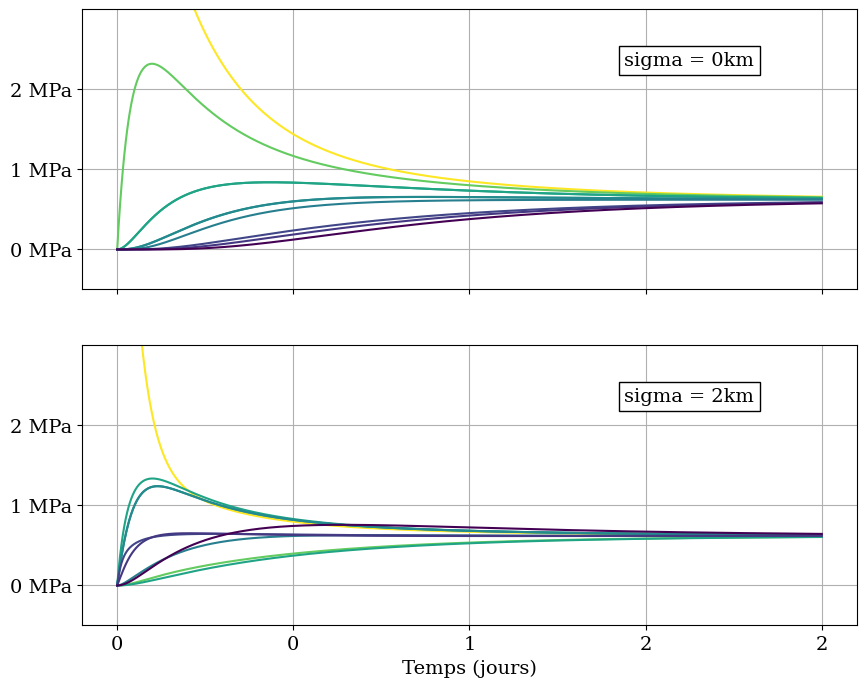

In [83]:
# Plot des deux cas aux limites
depths = sills_xyzR_variantes[0][0:,2]*1e-3
color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=depths.min(), vmax=depths.max()), cmap='viridis')

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,8), sharex=True)

for i in range(n_sills):
    ax1.plot(time_free/(24*3600), pressions_free[0,:,i], color=color_map.to_rgba(depths[i]), label='%d' % i)
    ax2.plot(time_free/(24*3600), pressions_free[-1,:,i], color=color_map.to_rgba(depths[i]), label='%d' % i)

ax1.yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x*1e-6:.0f} MPa"))
ax1.set_yticks([0, 1e6, 2e6])

ax2.yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x*1e-6:.0f} MPa"))
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x:.0f}"))
ax2.set_yticks([0, 1e6, 2e6])
ax2.set_xticks([0, .5,1,1.5, 2])

box_props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax1.text(0.7, 0.85,f"sigma = {r_std[-0]:.0f}km",transform=ax1.transAxes, verticalalignment='top', bbox=box_props)
ax2.text(0.7, 0.85,f"sigma = {r_std[-1]:.0f}km",transform=ax2.transAxes, verticalalignment='top', bbox=box_props)

ax1.set_ylim([-0.05e7,0.3e7])
ax2.set_ylim([-0.05e7,0.3e7])
ax1.grid()
ax2.grid()

ax2.set_xlabel("Temps (jours)")

# plt.colorbar(color_map,ax=ax1, label="Profondeur de la chambre (km)")
# plt.savefig("./figures_inversion_pdf/connectivite_diffusion_pression.pdf")
plt.show()


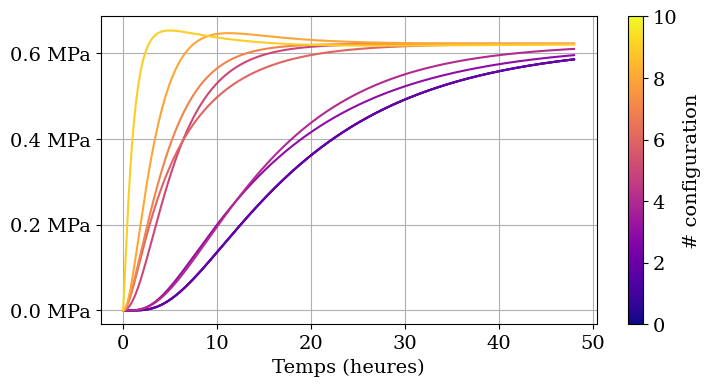

In [84]:
# On plot les pressions dans le sill supérieur au cours du temps pour les différentes configurations

color_map_config = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=n_config), cmap='plasma')

fig,ax = plt.subplots(figsize=(8,4))

for i in range(n_config):
    ax.plot(time_free/3600, pressions_free[i,:,-2], color=color_map_config.to_rgba(i), label='%d' % i)

ax.grid()
# ax.set_ylabel("Pressure (MPa)")
ax.set_xlabel("Temps (heures)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x*1e-6:.1f} MPa"))
plt.colorbar(color_map_config,ax=ax, label="# configuration")

# plt.savefig("./figures_inversion_pdf/pression_sills_sup_free.pdf")
plt.show()

### B. Forçage externe

Chambre du bas connectée à un réservoir à 1 MPa

In [89]:
# Cas forçage externe : seule la première chambre est connectée à la source
source = np.zeros(n_sills)
source[0] = 1
p_source = 1e6
p0 = np.zeros(n_sills)

# Temps 
t_stop = 24*3600*10
n_time = 1000
time_forced = np.linspace(0.,t_stop,n_time)

# Résolution
pressions_forced = np.zeros((n_config,n_time,n_sills))

for i in range(n_config):
    p = solve_analytically_forced(graphs_variantes[i], p0, source, p_source, time_forced)
    pressions_forced[i,:,:] = p

In [90]:
# Plot de toutes les time series 

for k,r_s in enumerate(r_std):
    
    fig,ax = plt.subplots(figsize=(8,4))

    for i in range(n_sills):
        ax.plot(time_forced/(24*3600), pressions_forced[k,:,i], color=color_map.to_rgba(i), label='%d' % i)
        
    # ax.set_ylim([-0.05e6,0.3e6])
    ax.grid()

    plt.savefig(f"./figures/r_std={r_s:.1f}_pressions_forced.png")
    plt.close(fig)

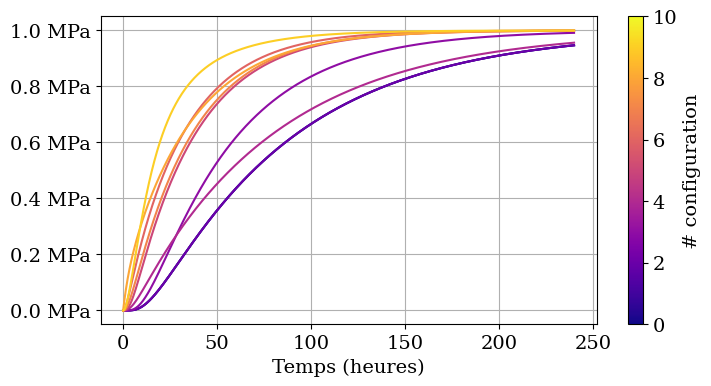

In [91]:
# Plot de la pression dans la chambre supérieure

fig,ax = plt.subplots(figsize=(8,4))

for i in range(n_config):
    ax.plot(time_forced/3600, pressions_forced[i,:,-1], color=color_map_config.to_rgba(i), label='%d' % i)

ax.grid()
# ax.set_ylabel("Pressure (MPa)")
ax.set_xlabel("Temps (heures)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x*1e-6:.1f} MPa"))
plt.colorbar(color_map_config,ax=ax, label="# configuration")

plt.savefig("./figures_inversion_pdf/pression_sills_sup_forced.pdf")
plt.show()

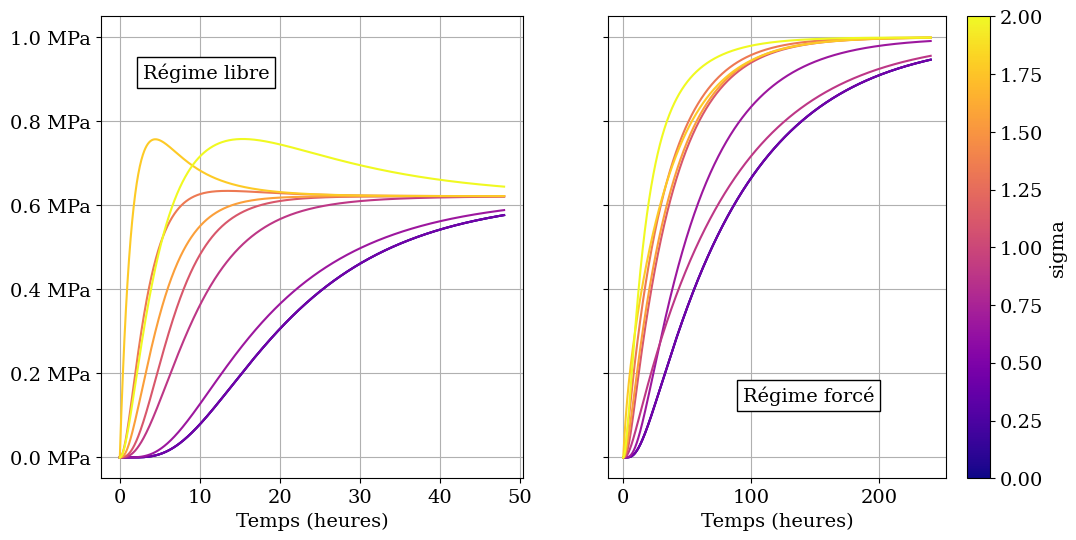

In [102]:
# Plot des deux en mm temps

color_map_sigma = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=2), cmap='plasma')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6),sharey=True)

for i in range(n_config):
    ax1.plot(time_free/3600, pressions_free[i,:,-1], color=color_map_sigma.to_rgba(r_std[i]), label='%d' % i)
    ax2.plot(time_forced/3600, pressions_forced[i,:,-1], color=color_map_sigma.to_rgba(r_std[i]), label='%d' % i)

ax1.grid()
ax2.grid()
# ax.set_ylabel("Pressure (MPa)")
ax1.set_xlabel("Temps (heures)")
ax2.set_xlabel("Temps (heures)")

ax1.yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x*1e-6:.1f} MPa"))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f"{x*1e-6:.1f} MPa"))

box_props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax1.text(0.1, 0.9,"Régime libre",transform=ax1.transAxes, verticalalignment='top', bbox=box_props)
ax2.text(0.4, 0.2,"Régime forcé",transform=ax2.transAxes, verticalalignment='top', bbox=box_props)


plt.colorbar(color_map_sigma,ax=ax2, label="sigma")

plt.savefig("./figures_pdf/pression_sills_sup.pdf")
# plt.show()